# Project description

In this project, we aim to characterise the effect of Foxa2 in the determination of endoderm and mesoderm lineages in the mouse embryo.

**In this notebook:** Pre-processing and batch correction of the data. 

# Initialisation

In [1]:
import numpy as np
import scipy as sci
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as pl

import scanpy as sc
import anndata as ann
import gseapy as gp
import scvelo as scv

from scipy.sparse import csr_matrix
from matplotlib import rcParams
from matplotlib import colors
from seaborn import heatmap
from matplotlib import gridspec

import os
import fnmatch

sc.settings.verbosity = 3
sc.logging.print_versions()

scanpy==1.4.5.2.dev6+gfa408dc7 anndata==0.7.1 umap==0.3.10 numpy==1.17.4 scipy==1.3.1 pandas==0.25.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


In [2]:
#%matplotlib inline
#%config InlineBackend.figure_format='retina' # mac

sc.settings.set_figure_params(dpi=70)
sc.settings.verbosity = 3
sc.settings.n_jobs = 3
data_dir = './../raw_data/'

In [3]:

sc.set_figure_params(vector_friendly=True,color_map='viridis',dpi_save=600,transparent=True)

In [4]:
import datetime

today = datetime.date.today().strftime('%y%m%d')

# Load dataset

In [4]:
all_files = os.listdir(data_dir)
files = np.array([file_id.startswith('170517') for file_id in all_files])

In [5]:
batch_names = [tmp.split('170517_')[1] for tmp in np.array(all_files)[files]]

In [6]:
#load all datasets into a list
adata_list = []
for folder in enumerate(np.array(all_files)[files]):
    print('Read file ' + folder[1])
    adatas = sc.read_10x_mtx(data_dir + folder[1] + '/filtered_gene_bc_matrices/mm10/')
    print('The currently read data file has ' + str(adatas.n_obs) + ' observations.')
    adata_list.append(adatas)

Read file 170517_fvf_neg_2
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
The currently read data file has 2963 observations.
Read file 170517_fvf_high_2
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
The currently read data file has 412 observations.
Read file 170517_fvf_low_1
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
The currently read data file has 848 observations.
Read file 170517_fvf_high_3
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
The currently read data file has 947 observations.
Read file 170517_fvf_neg_1
--> This might be very slow. Consider passing `cache=True`, which enables much faster reading from a cache file.
The currently read data file has 1219 observations.
Read file 170517_fvf_high_1
--> This migh

In [11]:
adata_concatenated = ann.AnnData.concatenate(
    *adata_list, 
    batch_key = 'batch', 
    batch_categories = batch_names,
).copy()

In [12]:
adata_concatenated

AnnData object with n_obs × n_vars = 9852 × 27998 
    obs: 'batch'
    var: 'gene_ids'

In [13]:
adata_concatenated.obs['batch'] = adata_concatenated.obs['batch'].cat.reorder_categories(
    ['fvf_neg_1', 'fvf_neg_2', 'fvf_low_1', 'fvf_low_2', 'fvf_low_3',
     'fvf_high_1', 'fvf_high_2', 'fvf_high_3'])

In [14]:
adata_concatenated.obs['batch'].value_counts()

fvf_neg_2     2963
fvf_neg_1     1219
fvf_low_2     1182
fvf_low_3     1172
fvf_high_1    1109
fvf_high_3     947
fvf_low_1      848
fvf_high_2     412
Name: batch, dtype: int64

In [15]:
sc.write('./../data/adata_concatenated.h5ad',adata_concatenated)

In [5]:
adata_concatenated = sc.read('./../data/adata_concatenated.h5ad')

In [7]:
adata_concatenated.obs['batch'].value_counts().to_csv('./../table/n_cells_preQC.csv')

# Pre-processing

In [16]:
# Quality control - calculate QC covariates for all anndata objects
adata_concatenated.obs['n_counts'] = adata_concatenated.X.sum(1)
adata_concatenated.obs['n_genes'] = (adata_concatenated.X > 0).sum(1)
mt_gene_mask = [gene.startswith('mt-') for gene in adata_concatenated.var_names]
mt_gene_index = np.where(mt_gene_mask)[0]
adata_concatenated.obs['mt_fraction'] = adata_concatenated.X[:,mt_gene_index].sum(1) / adata_concatenated.X.sum(1)

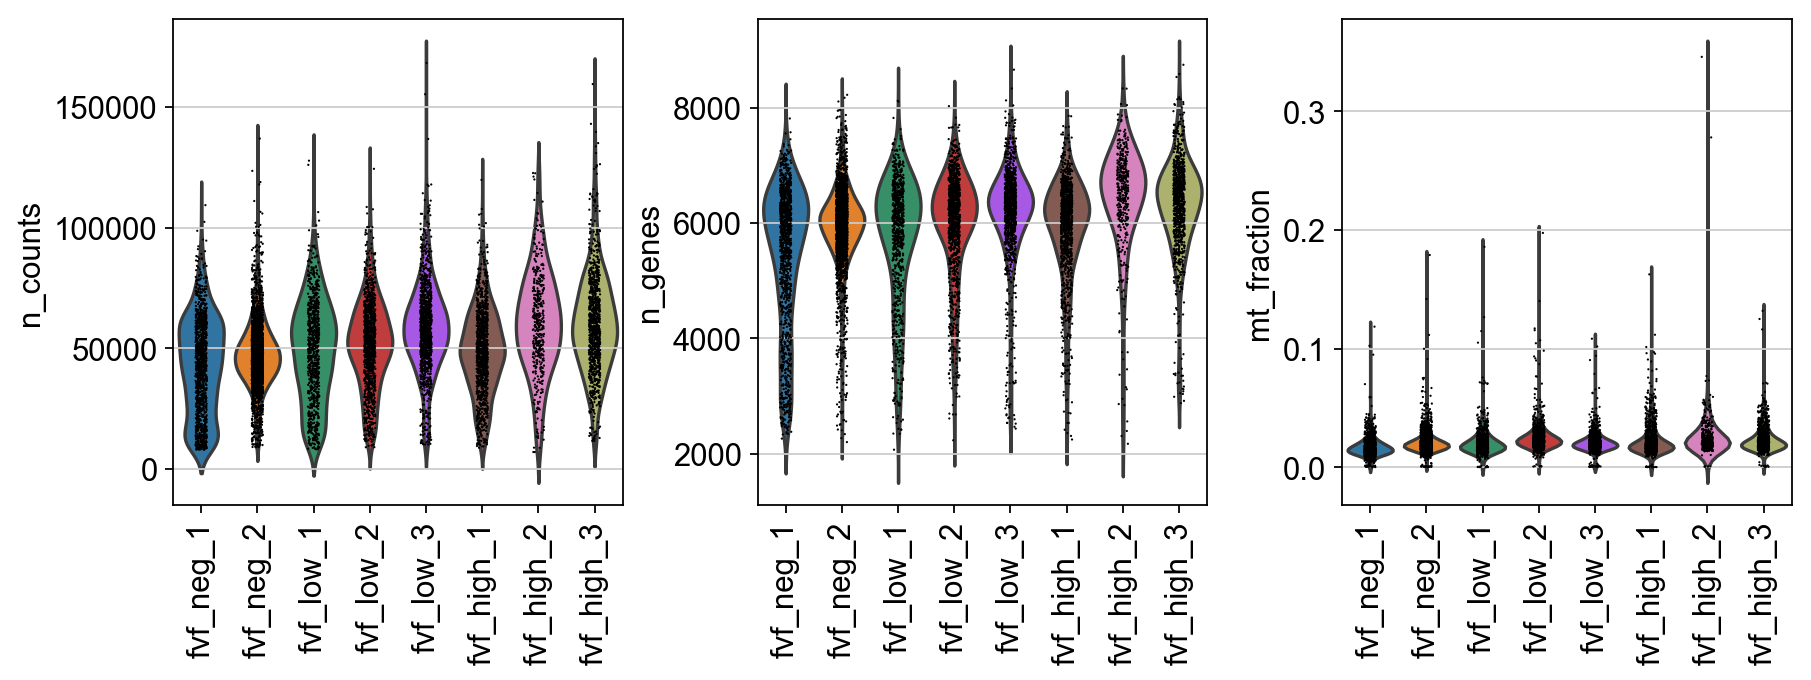

In [17]:
# Quality control - plot QC metrics
#Sample quality plots
sc.pl.violin(adata_concatenated, ['n_counts','n_genes', 'mt_fraction'], 
             groupby='batch', size=1, log=False,rotation=90)
#sc.pl.violin(alldays, 'mt_frac', groupby='day')

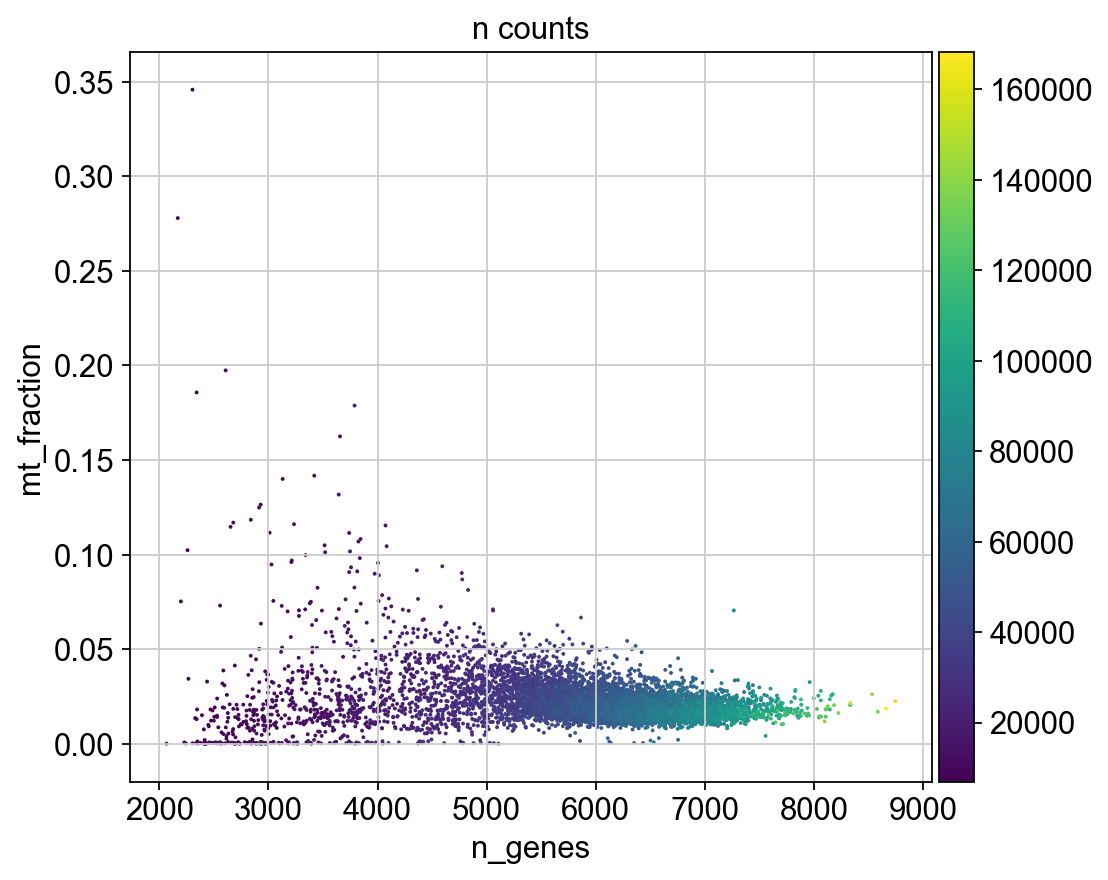

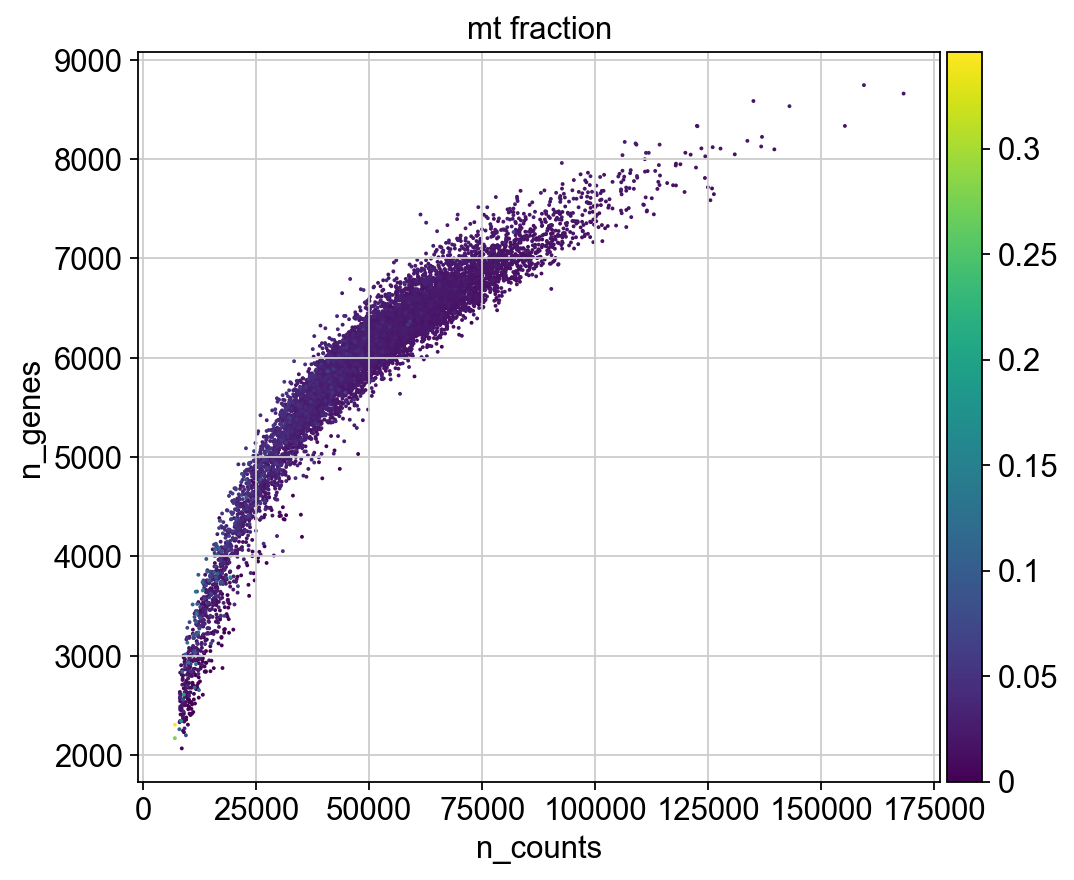

In [18]:
rcParams['figure.figsize']=(6,6)
sc.pl.scatter(adata_concatenated,x='n_genes',y='mt_fraction',color='n_counts')
sc.pl.scatter(adata_concatenated,y='n_genes',x='n_counts',color='mt_fraction')

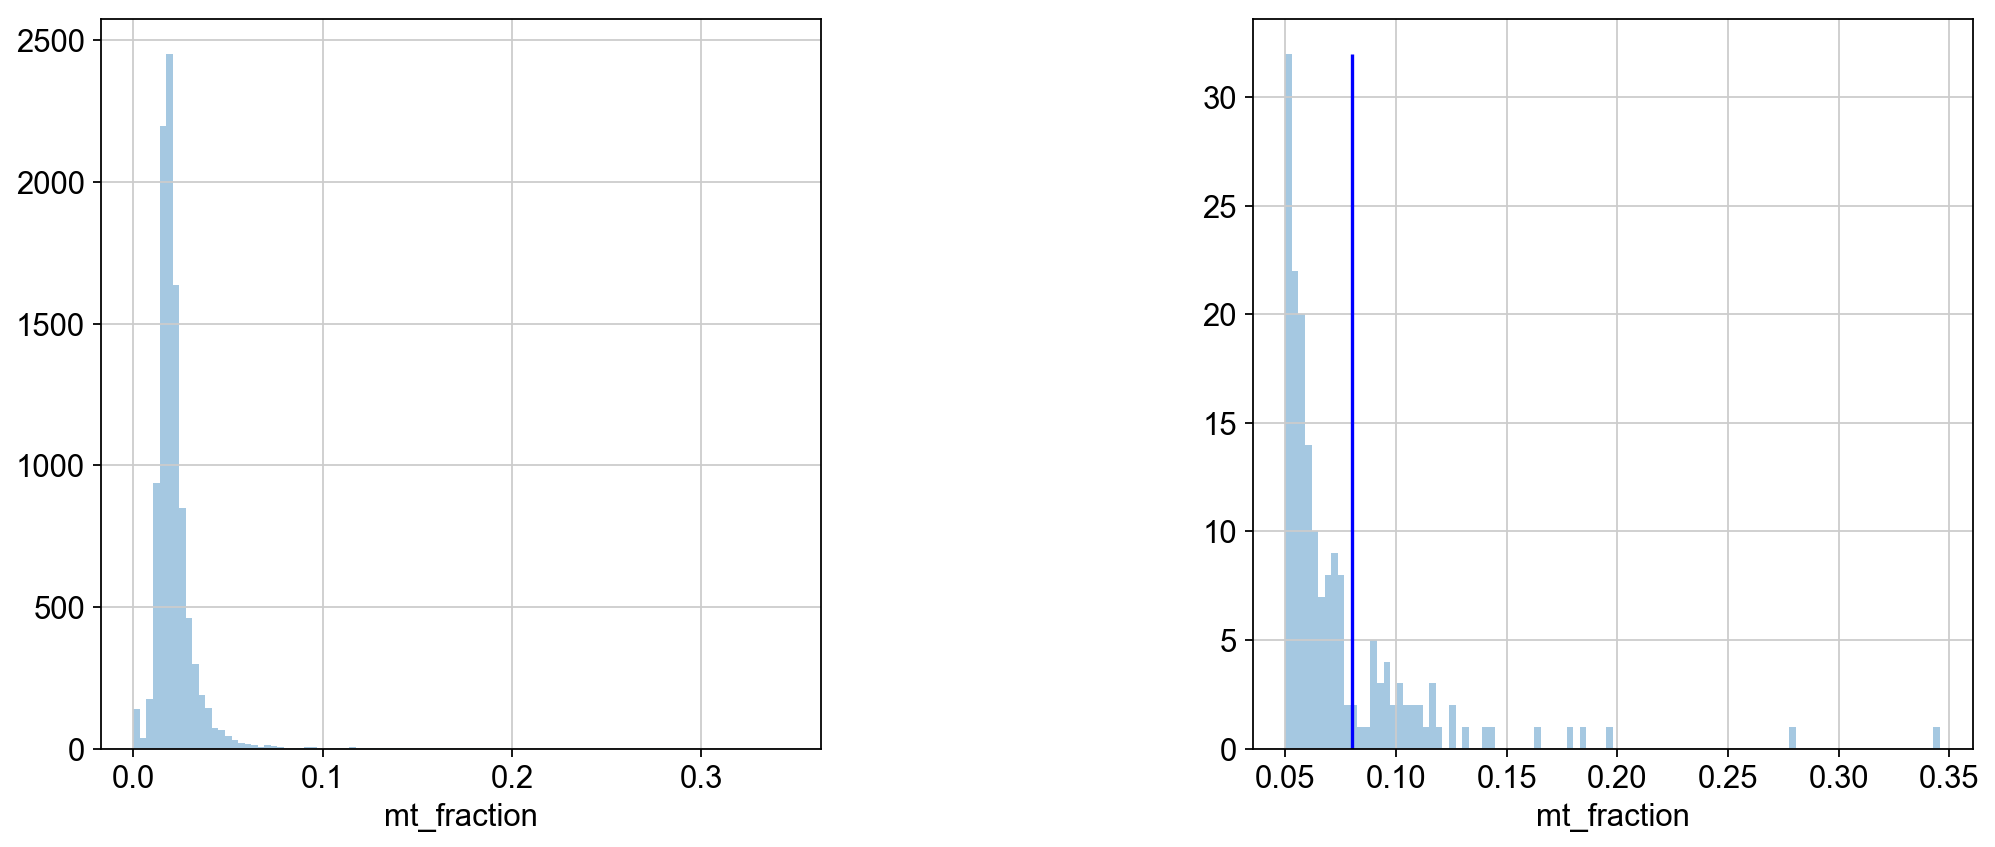

In [19]:
rcParams['figure.figsize']=(15,6)
fig_ind=np.arange(121, 123)

fig = pl.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)
ax = fig.add_subplot(fig_ind[0])
p0 = sb.distplot(adata_concatenated.obs['mt_fraction'], bins=100, kde=False, ax=ax)   
ax = fig.add_subplot(fig_ind[1])
p1 = sb.distplot(adata_concatenated.obs['mt_fraction'][adata_concatenated.obs['mt_fraction']>0.05], 
                 bins=100, kde=False, ax=ax)
ax.vlines(0.08,0, 32, colors='blue')

pl.show()


## cell filtering

In [20]:
#Filter cells according to identified QC thresholds:
print('Total number of cells: {:d}'.format(adata_concatenated.n_obs))

adata_concatenated = adata_concatenated[adata_concatenated.obs['mt_fraction'] < 0.08]
print('Number of cells after MT filter: {:d}'.format(adata_concatenated.n_obs))

adata_concatenated = adata_concatenated[adata_concatenated.obs['n_genes'] > 1000]
print('Number of cells after number of expressed genes filter: {:d}'.format(adata_concatenated.n_obs))

sc.pp.filter_cells(adata_concatenated, max_counts=125000)
print('Number of cells after count filter: {:d}'.format(adata_concatenated.n_obs))



Total number of cells: 9852
Number of cells after MT filter: 9809
Number of cells after number of expressed genes filter: 9809
filtered out 15 cells that have more than 125000 counts


Trying to set attribute `.obs` of view, making a copy.


Number of cells after count filter: 9794


## gene filtering

In [21]:
#Filter genes:
print('Total number of genes: {:d}'.format(adata_concatenated.n_vars))

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(adata_concatenated, min_cells=10)
print('Number of genes after cell filter: {:d}'.format(adata_concatenated.n_vars))

Total number of genes: 27998
filtered out 10497 genes that are detected in less than 10 cells
Number of genes after cell filter: 17501


## QC after pre-processing

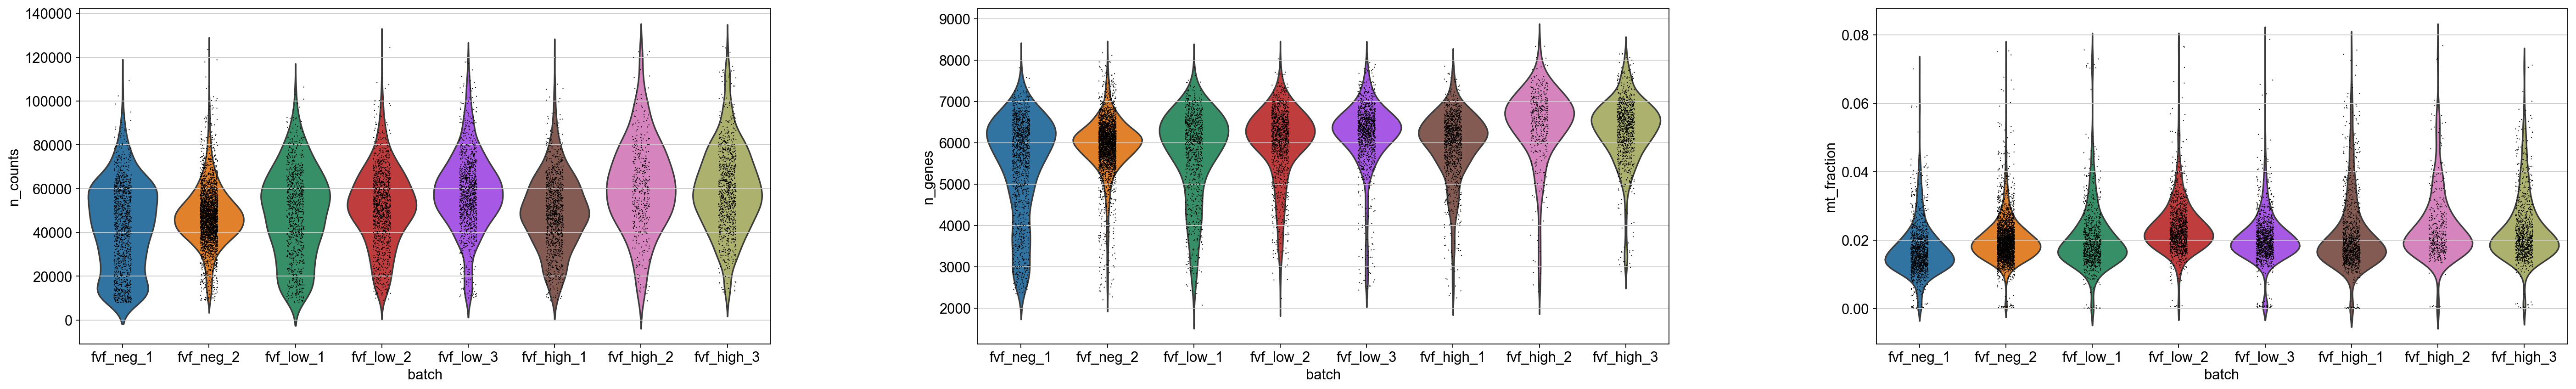

mean_genes  median_genes   mean_counts  median_counts
batch                                                             
fvf_neg_1   5409.566612        5787.0  42503.871094        43985.0
fvf_neg_2   5936.312817        6011.0  47301.847656        46614.0
fvf_low_1   5725.073634        6031.5  48557.312500        50253.5
fvf_low_2   5992.474808        6175.0  51362.675781        52308.0
fvf_low_3   6169.369957        6308.0  58063.390625        57858.0
fvf_high_1  5935.664845        6105.0  48962.281250        48771.0
fvf_high_2  6437.804878        6599.0  60740.058594        60504.5
fvf_high_3  6304.463102        6415.0  59558.632812        58674.0

In [22]:
rcParams['figure.figsize']=(10,6)
sc.pl.violin(adata_concatenated, ['n_counts','n_genes', 'mt_fraction'], 
             groupby='batch', size=1, log=False)

df = adata_concatenated.obs[['n_genes','n_counts','batch']]
df_all = pd.DataFrame(df.groupby(by='batch')['n_genes'].apply(np.mean).values,
                      index=df.groupby(by='batch')['n_genes'].apply(np.mean).index,
                      columns=['mean_genes'])

df_all['median_genes']=df.groupby(by='batch')['n_genes'].apply(np.median).values
df_all['mean_counts']=df.groupby(by='batch')['n_counts'].apply(np.mean).values
df_all['median_counts']=df.groupby(by='batch')['n_counts'].apply(np.median).values
df_all

Check number of cells post-processing and save to file.

In [11]:
adata_concatenated.obs['batch'].value_counts().to_csv('./../table/n_cells_postQC.csv')

## Normalization

We use the logCPM normalization for the data.

In [24]:
sc.pp.normalize_per_cell(adata_concatenated, counts_per_cell_after = 5e4)

normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


In [25]:
sc.pp.log1p(adata_concatenated)


## Highly variable gene selection

In [26]:
sc.pp.highly_variable_genes(adata_concatenated, flavor='cell_ranger', 
                            n_top_genes=3000, batch_key='batch')

extracting highly variable genes
    finished (0:00:05)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


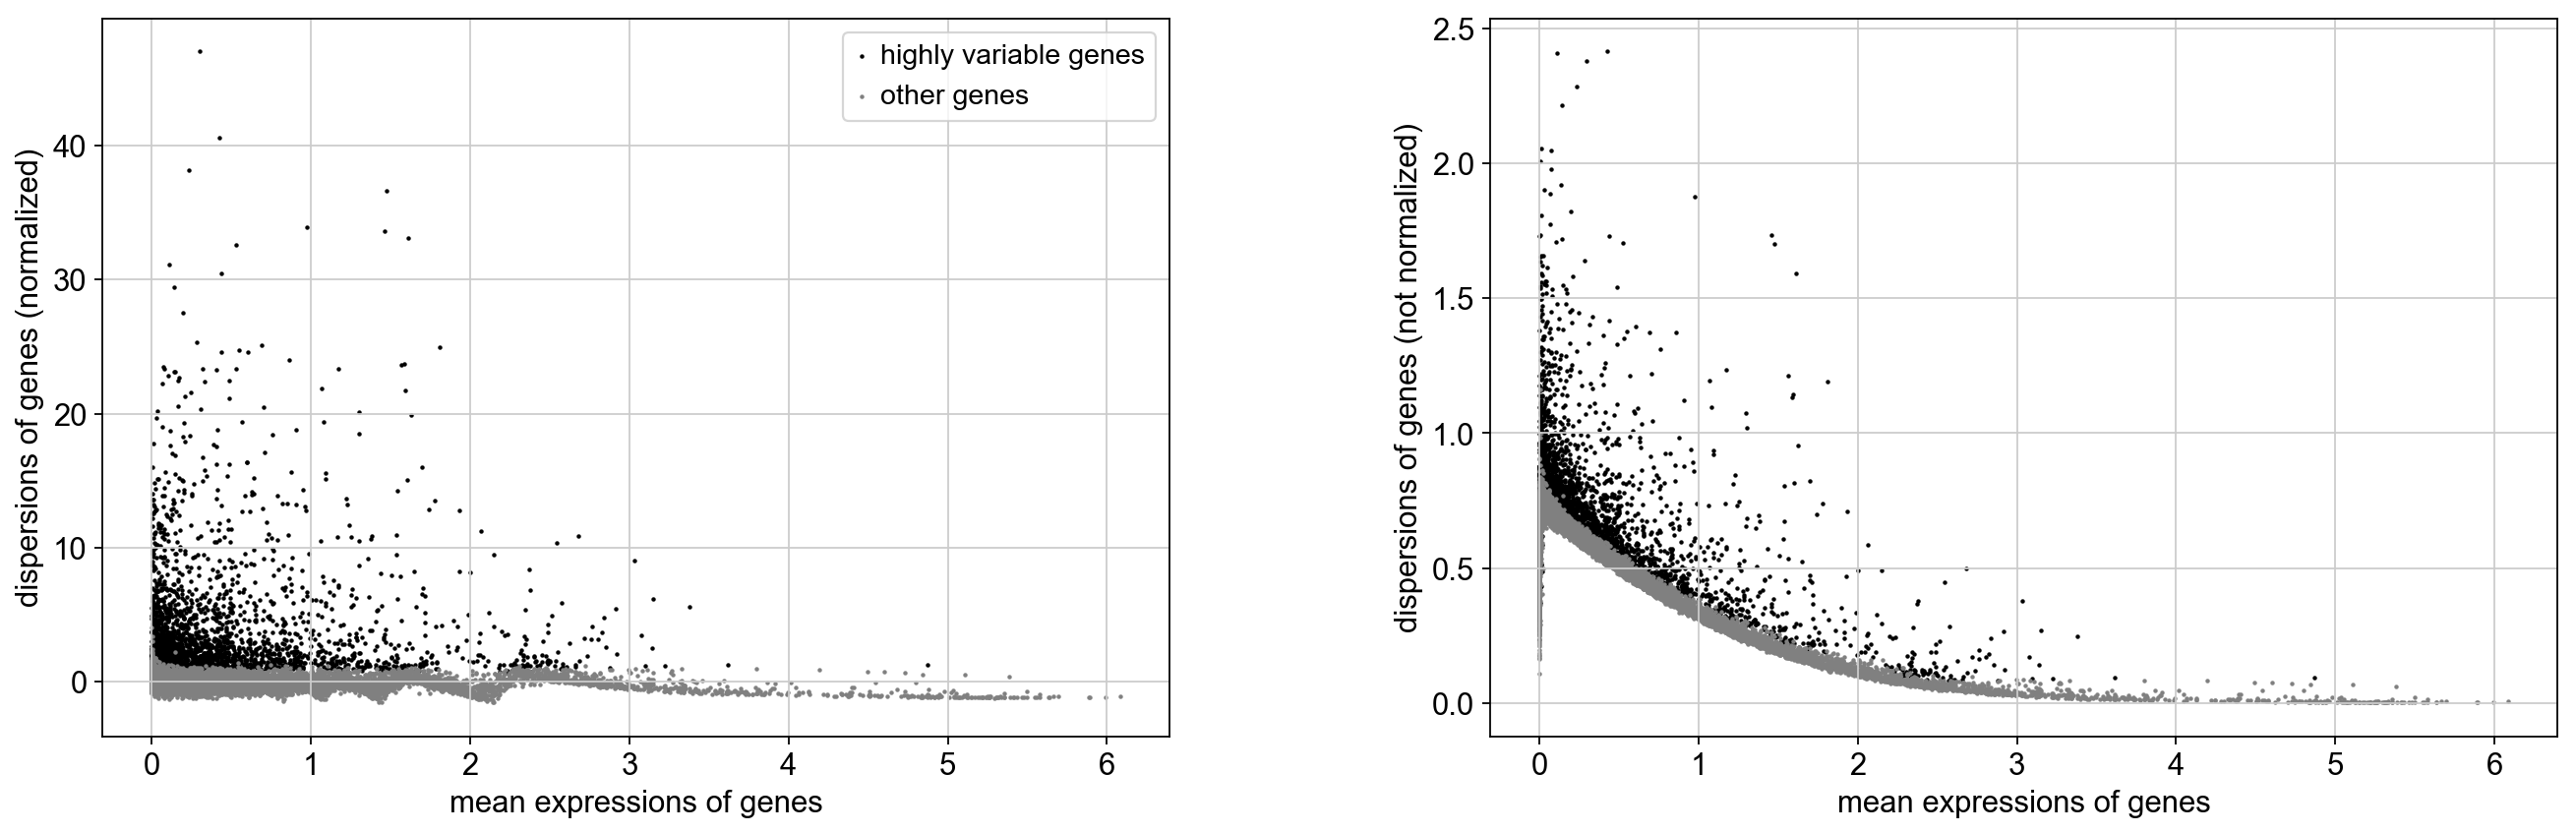

In [27]:
sc.pl.highly_variable_genes(adata_concatenated)


## Compute cell cycle

In [28]:
cc_genes_file = './../raw_data/Macosko_cell_cycle_genes.txt'

In [29]:
cc_genes = pd.read_table(cc_genes_file, delimiter='\t')
s_genes = cc_genes['S'].dropna()
g2m_genes = cc_genes['G2.M'].dropna()

s_genes_mm = [gene.lower().capitalize() for gene in s_genes]
g2m_genes_mm = [gene.lower().capitalize() for gene in g2m_genes]

s_genes_hvg = adata_concatenated.var_names[np.in1d(adata_concatenated.var_names, s_genes_mm)]
g2m_genes_hvg = adata_concatenated.var_names[np.in1d(adata_concatenated.var_names, g2m_genes_mm)]

sc.tl.score_genes_cell_cycle(adata_concatenated, s_genes=s_genes_hvg, g2m_genes=g2m_genes_hvg)

calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs) (0:00:02)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs) (0:00:03)
-->     'phase', cell cycle phase (adata.obs)


In [30]:
pd.value_counts(adata_concatenated.obs['phase'])

G2M    8807
S       958
G1       29
Name: phase, dtype: int64

In [26]:
#adata.obs['phase'] = adata_concatenated.obs['phase']

# Embedding

In [31]:
sc.pp.pca(adata_concatenated, svd_solver='arpack')
sc.pp.neighbors(adata_concatenated)

computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:07)


# Visualization

In [32]:
sc.tl.umap(adata_concatenated)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)


... storing 'phase' as categorical


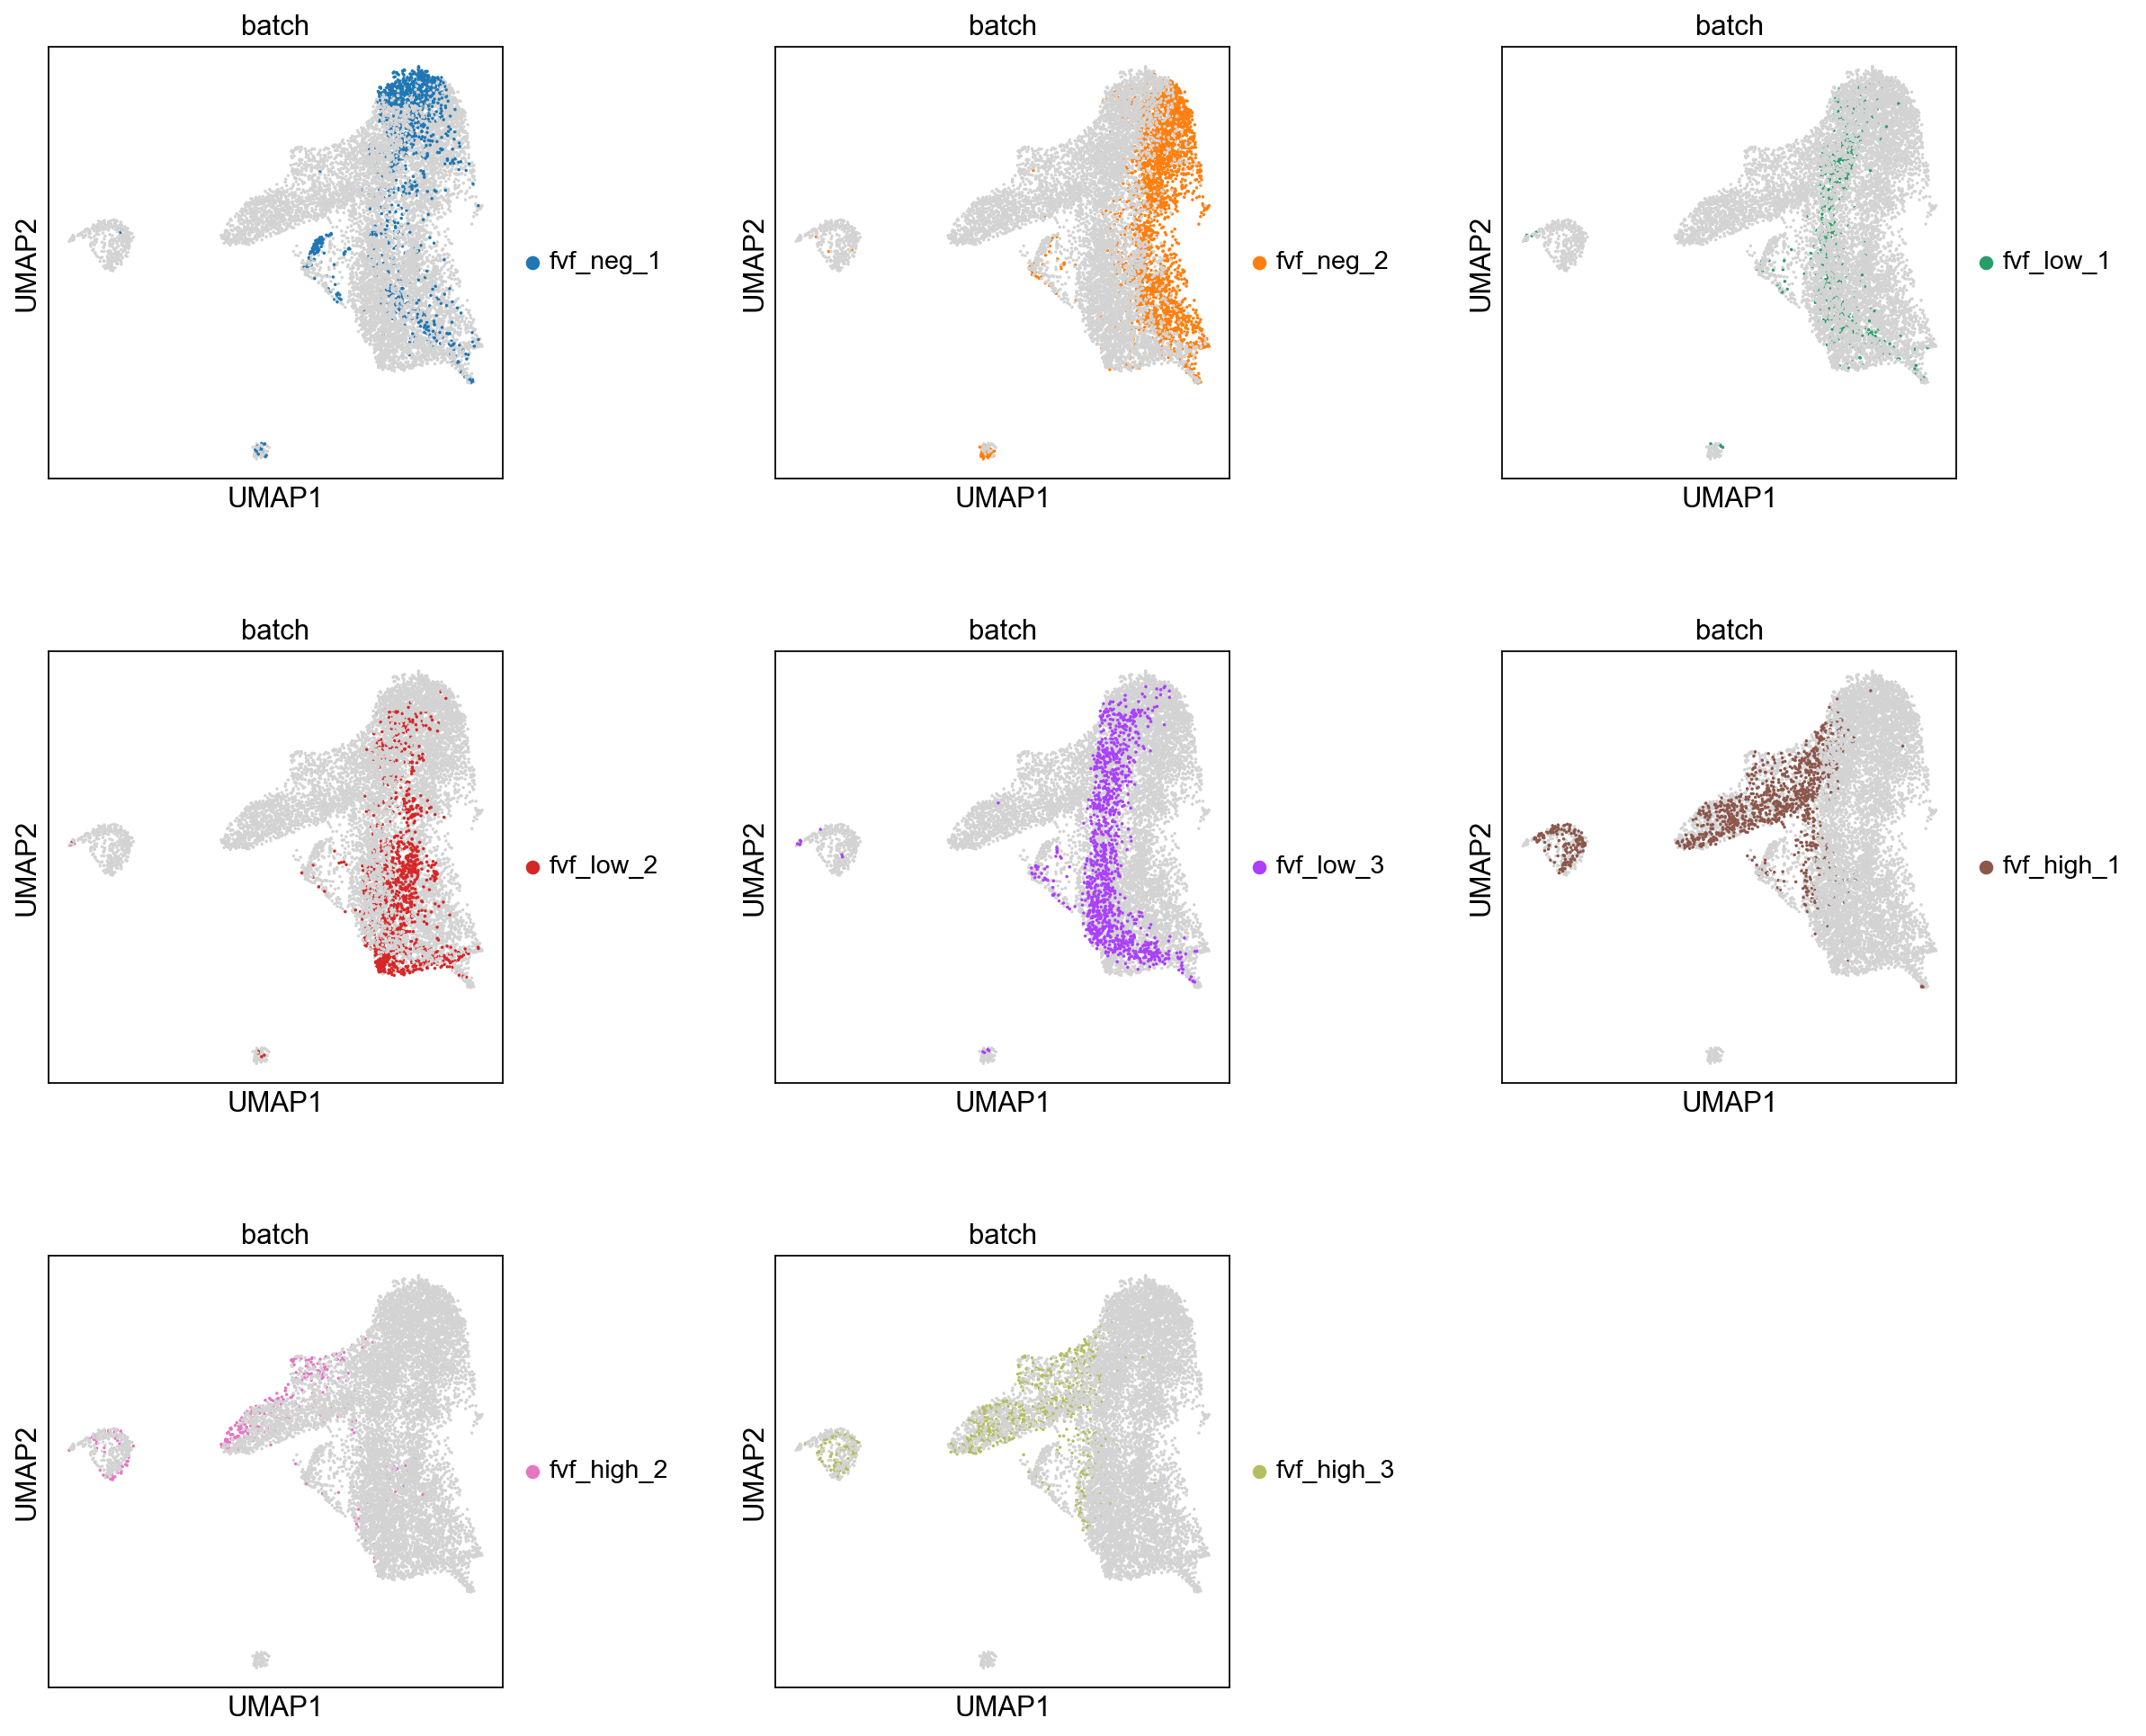

In [33]:
rcParams['figure.figsize']=(17,15)
fig_ind=np.arange(331, 339)
fig = pl.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

for group in enumerate(fig_ind):
    ax = fig.add_subplot(group[1])
    sc.pl.umap(adata_concatenated,
               color=['batch'],
               groups=[adata_concatenated.obs['batch'].cat.categories[group[0]]],
               size=10, 
               ax=ax, show=False)

pl.show()

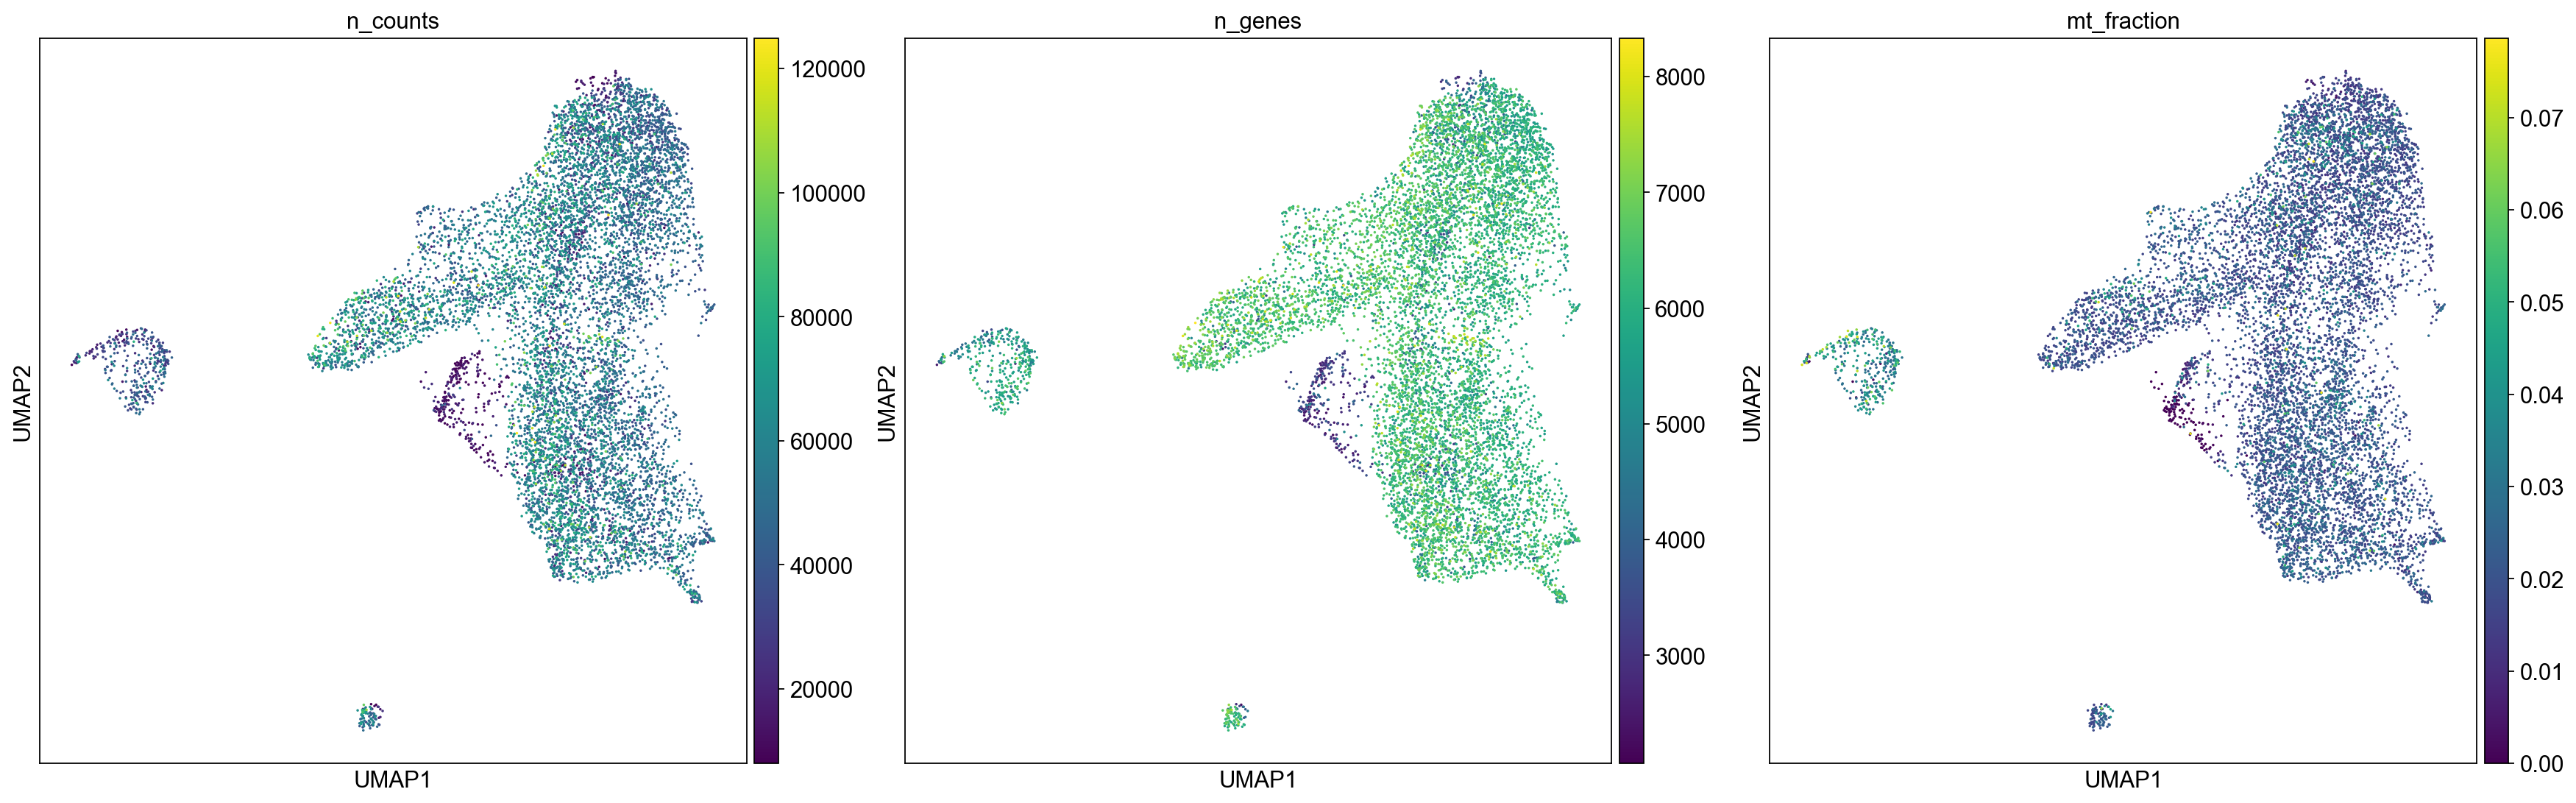

In [34]:
rcParams['figure.figsize']=(8,8)
sc.pl.umap(adata_concatenated,color=['n_counts','n_genes','mt_fraction'],size=10)

# Batch effect correction

We use scanorama for batch effect correction, because our samples are inhomogenous due to the FACS sorting. Other models like Combat are not suitable to correct the data because FVF high cells separate from FVF low/neg cells due to different cell type composition.

## Using scanorama

In [1]:
import scanorama as scan

/Users/maren.buettner/anaconda3/envs/scanpy_test/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [36]:
adata_logCPM = adata_concatenated.copy()

In [37]:
#from scIB package

def splitBatches(adata, batch, hvg= None):
    split = []
    if hvg is not None:
        adata = adata[:, hvg]
    for i in adata.obs[batch].unique():
        split.append(adata[adata.obs[batch]==i].copy())
    return split

In [38]:
split = splitBatches(adata_concatenated[:,adata_concatenated.var['highly_variable']].copy(), batch='batch')
emb, corrected = scan.correct_scanpy(split, return_dimred=True)
corrected = corrected[0].concatenate(corrected[1:])

Found 3000 genes among all datasets
[[0.         0.2097561  0.52850356 0.08128342 0.77055921 0.05100182
  0.7147737  0.50214592]
 [0.         0.         0.08780488 0.87317073 0.00731707 0.7804878
  0.21434671 0.10731707]
 [0.         0.         0.         0.22565321 0.67458432 0.41686461
  0.56650831 0.73733906]
 [0.         0.         0.         0.         0.05263158 0.92299465
  0.14517506 0.3416309 ]
 [0.         0.         0.         0.         0.         0.16694079
  0.24081981 0.48669528]
 [0.         0.         0.         0.         0.         0.
  0.17847993 0.39227468]
 [0.         0.         0.         0.         0.         0.
  0.         0.77339056]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]
Processing datasets (3, 5)
Processing datasets (1, 3)
Processing datasets (1, 5)
Processing datasets (6, 7)
Processing datasets (0, 4)
Processing datasets (2, 7)
Processing datasets (0, 6)
Processing datasets (2, 4)
Processing datasets (2, 6)
P

In [39]:
sc.pp.pca(corrected, svd_solver='arpack')
sc.pp.neighbors(corrected)

computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:02)


In [40]:
sc.tl.umap(corrected)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:13)


/Users/maren.buettner/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


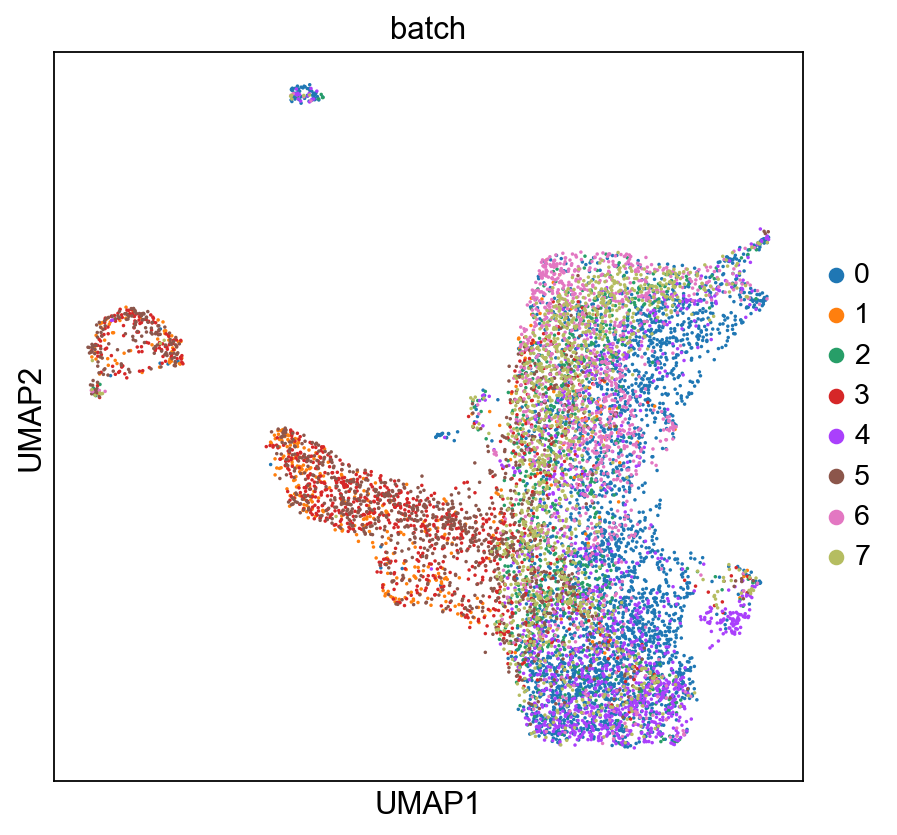

In [41]:
rcParams['figure.figsize']=(6,6)
sc.pl.umap(corrected, color='batch', size=10)

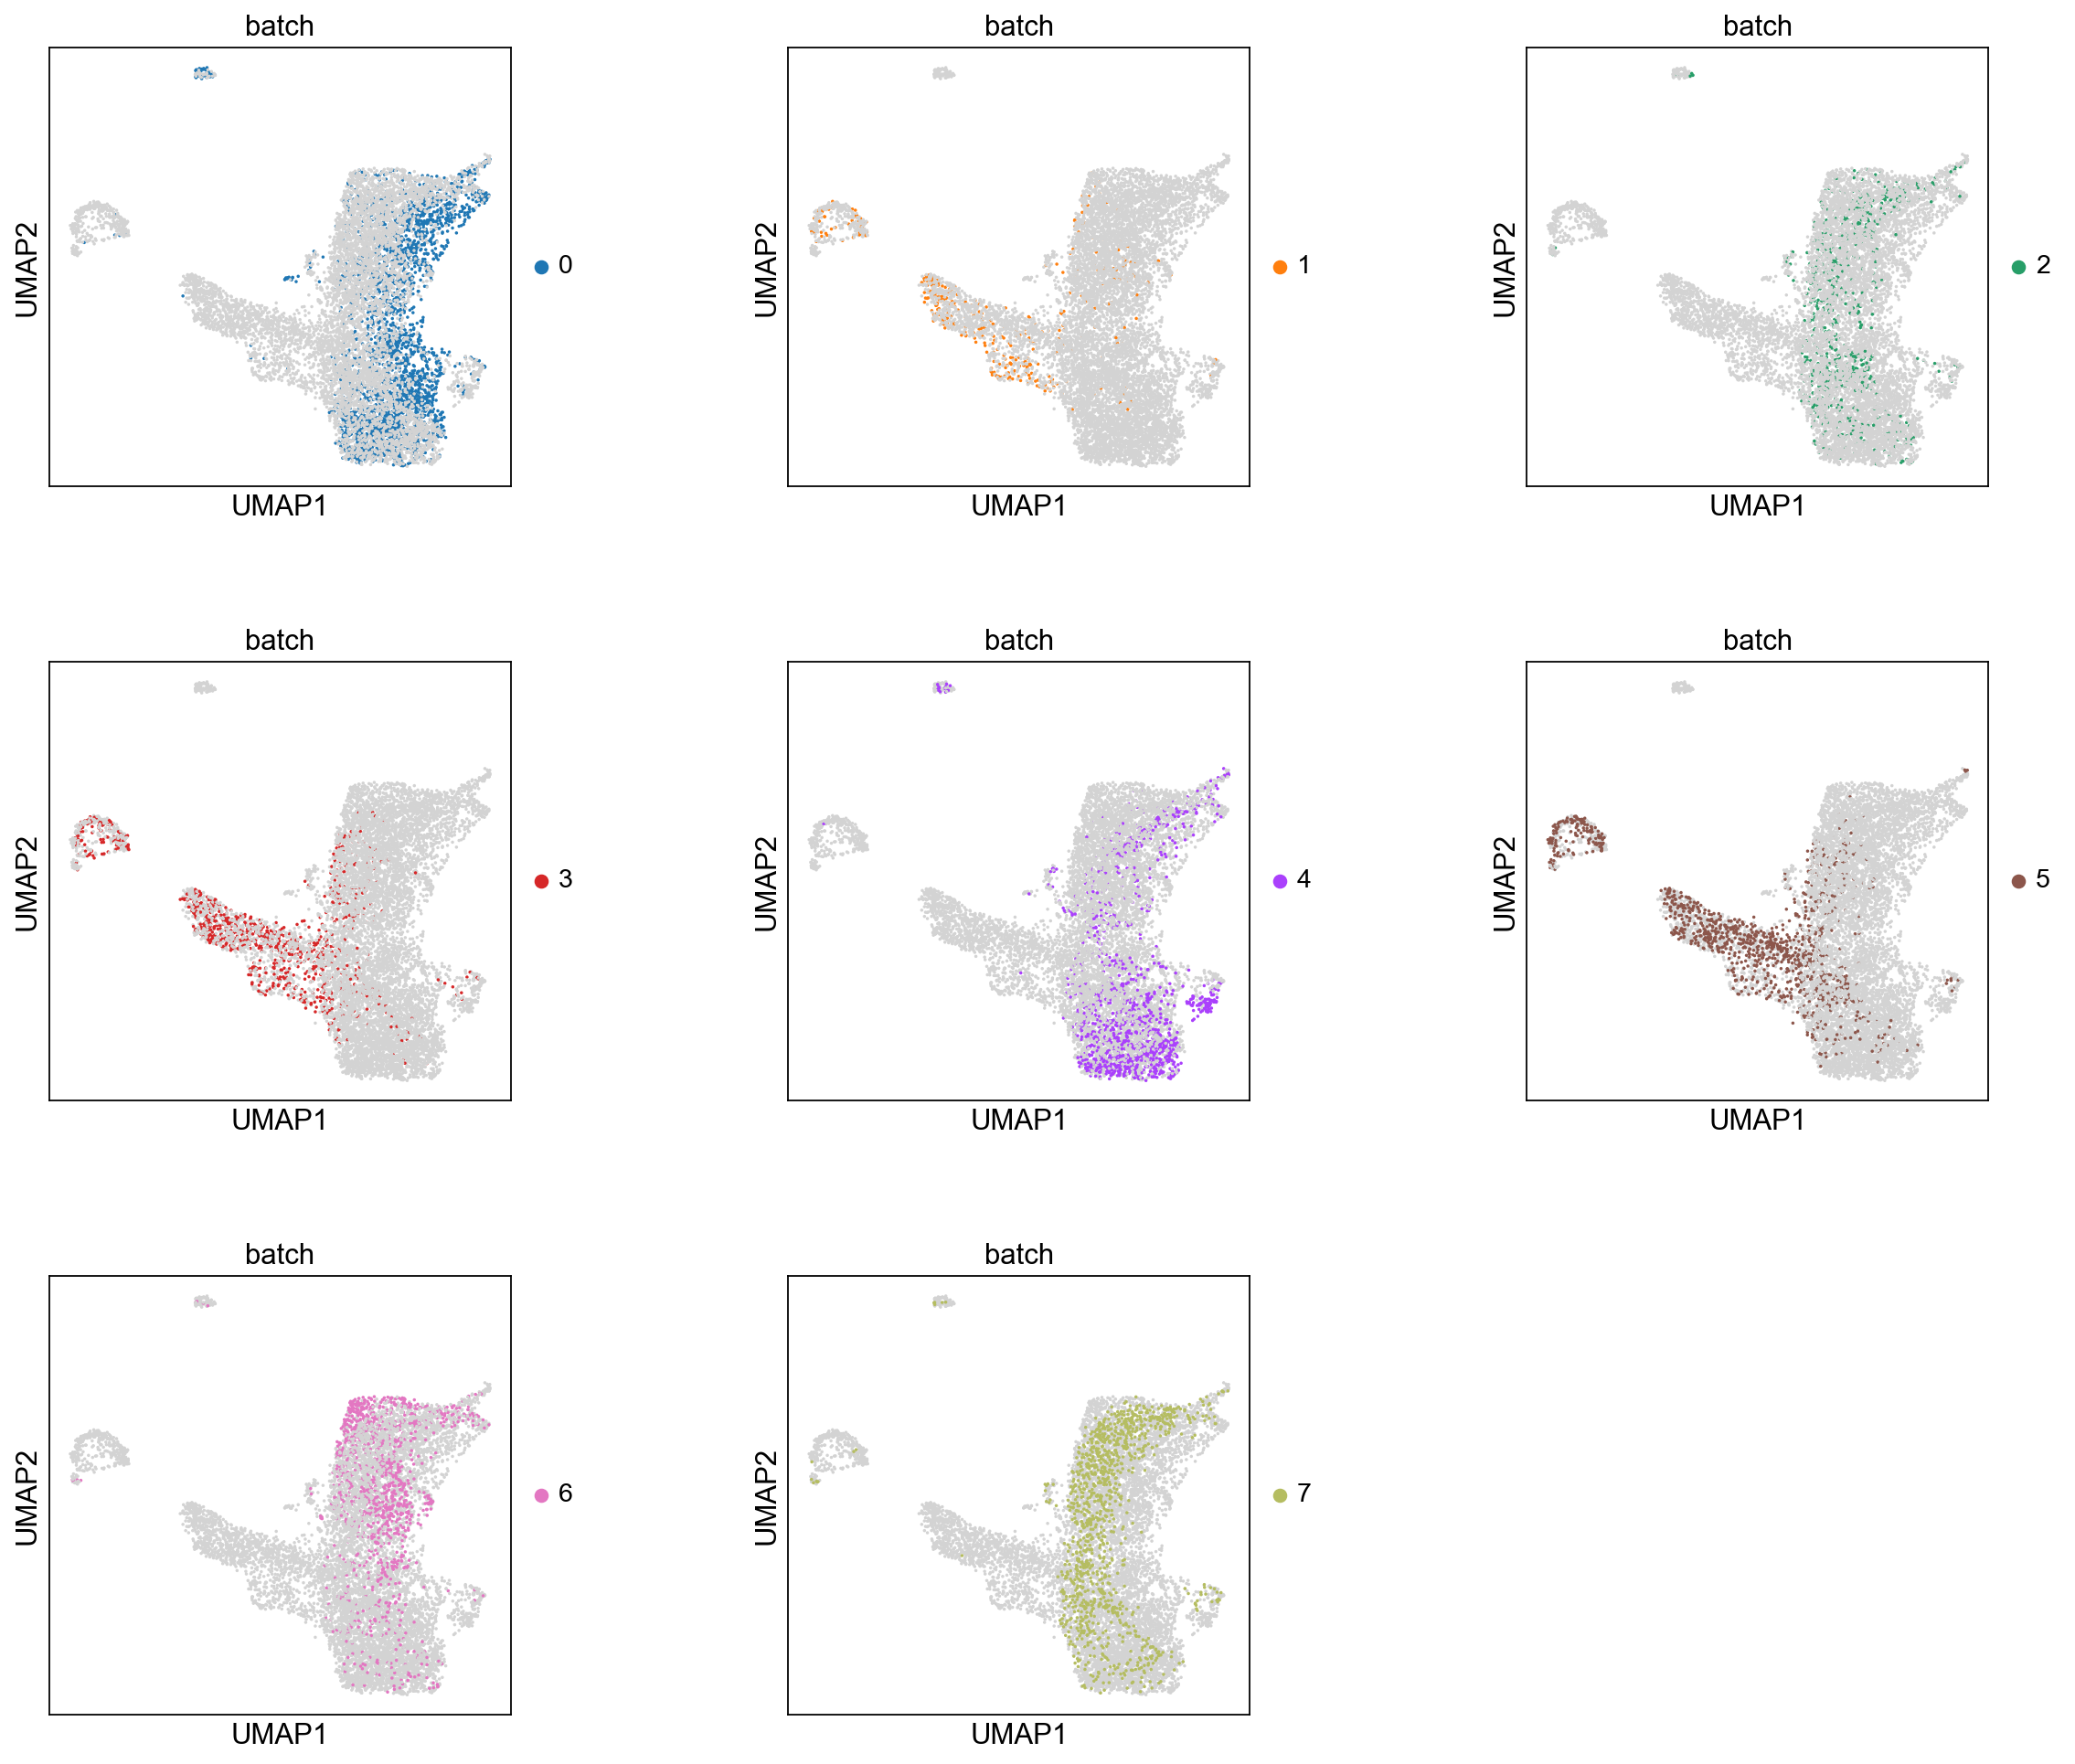

In [42]:
rcParams['figure.figsize']=(17,15)
fig_ind=np.arange(331, 339)
fig = pl.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.6)

for group in enumerate(fig_ind):
    ax = fig.add_subplot(group[1])
    sc.pl.umap(corrected,
               color=['batch'],
               groups=[corrected.obs['batch'].cat.categories[group[0]]],
               size=10, 
               ax=ax, show=False)

pl.show()

## Save to file

Before saving to file, we use the normalized data matrix as `raw` object in the corrected data matrix, which contains only the 3,000 highly variable genes.

In [45]:
adata = corrected.copy() 
adata.raw = adata_concatenated.copy()

adata.obs = adata_concatenated.obs
adata.obsm['X_umap'] = corrected.obsm['X_umap']
adata.obsm['X_pca'] = corrected.obsm['X_pca']
adata.uns['neighbors'] = corrected.uns['neighbors']

In [46]:
adata

AnnData object with n_obs × n_vars = 9794 × 3000 
    obs: 'batch', 'n_counts', 'n_genes', 'mt_fraction', 'S_score', 'G2M_score', 'phase'
    uns: 'pca', 'neighbors', 'batch_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'

In [48]:
sc.write('./../data/adata_batch_corrected.h5ad', adata)